In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import math
%matplotlib inline

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb

In [11]:
train = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/train.csv')
test = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/test.csv')
submission = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/submission.csv')


In [23]:
# 질문의 유형별로 분류
# VCL의 응답은 0, 1로
# question과 TIPI는 1 ~ 5 사이의 값으로
VCL_columns = ['VCL' + str(x + 1) for x in range(16)]
question_columns = ['Q' + str(x + 1) for x in range(26)]
TIPI_columns = ['TIPI' + str(x + 1) for x in range(10)]

survey_columns = []
survey_columns.extend(question_columns)
survey_columns.extend(TIPI_columns)

# 카테고리별로 분류
categorical_columns = ['gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'urban', 'country', 'nerdiness', 'education']
elapse_columns = ['introelapse', 'testelapse', 'surveyelapse', 'familysize']
numerical_columns = [column for column in train.columns if column not in categorical_columns]

# [카테고리 object] 결측값 -> 최빈값으로 변경
for category in categorical_columns:
    if category != 'nerdiness':
        train[category] = train[category].fillna(train[category].mode()[0])
        test[category] = test[category].fillna(test[category].mode()[0])
        train[category] = train[category].astype('str')
        test[category] = test[category].astype('str')
    else:
        train[category] = train[category].fillna(train[category].mode()[0])
        train[category] = train[category].astype('str')

    
# 연속형 변수 : float32, 결측값 -> 응답 : 3 (중간 값[이도저도 아니다])
for survey in survey_columns:
    train[survey] = train[survey].astype('float32')
    train[survey] = train[survey].fillna(3)
    test[survey] = test[survey].astype('float32')
    test[survey] = test[survey].fillna(3)

# 시간 관련 변수 -> 중앙값(중위값)으로 [median]
for elapse in elapse_columns:
    train[elapse] = train[elapse].astype('float32')
    train[elapse] = train[elapse].fillna(train[elapse].median())
    test[elapse] = test[elapse].astype('float32')
    test[elapse] = test[elapse].fillna(test[elapse].median())


In [24]:
# 마키아벨리즘에 대한 질문 점수
makia_survey = ['Q' + str(i+1) for i in range(26)]
not_makia = ['Q3', 'Q4', 'Q6','Q7', 'Q9', 'Q10', 'Q11', 'Q14', 'Q16', 'Q17', 'Q18',
            'Q21', 'Q22', 'Q23', 'Q23', 'Q24', 'Q25', 'Q26']

for columns in not_makia:
    train.loc[train[columns] > 0, columns] = 6 - train[columns]
    test.loc[test[columns] > 0, columns] = 6 - test[columns]



# 기준치 (60점 이상)에 관련된 파생변수 생성
train['makia_score'] = np.sum(train[makia_survey], axis = 1)
test['makia_score'] = np.sum(test[makia_survey], axis = 1)

train['high_makia'] = train['makia_score'].apply(lambda x : (1 if x > 60 else 0))
test['high_makia'] = test['makia_score'].apply(lambda x : (1 if x > 60 else 0))

train['high_makia'] = train['high_makia'].astype('str')
test['high_makia'] = test['high_makia'].astype('str')

In [25]:
'''
 TIPI에 대한 질문 점수
 TIPI는 1 ~ 7점까지 존재 -> 1 ~ 5점으로 변환
 TIPI 1점 -> 1점
 TIPI 2점 -> 2점
 TIPI 3점 -> 3점
 TIPI 4점 -> 3점
 TIPI 5점 -> 4점
 TIPI 6점 -> 4점 
 TIPI 7점 -> 5점
'''
TIPI_score = {1:1, 2:2, 3:4, 4:5, 4:6, 5:7}

for tipi in TIPI_columns:
    train[tipi] = train[tipi].map(TIPI_score)
    test[tipi] = test[tipi].map(TIPI_score)

train[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.386800,4.088200,4.790800,4.452200,5.448200,5.108400,4.881667,4.072067,4.273600,2.669067
std,1.882115,1.755551,1.643294,1.902163,1.441754,1.757097,1.651256,1.855704,1.761935,1.629395
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,1.000000
50%,4.000000,4.000000,4.000000,4.000000,6.000000,6.000000,4.000000,4.000000,4.000000,2.000000
75%,4.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [26]:
test[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,35452.000000,35452.000000,35452.000000,35452.000000,35452.00000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000
mean,3.379161,4.053509,4.762609,4.439439,5.45642,5.110741,4.895098,4.089163,4.284102,2.642446
std,1.894627,1.761814,1.658804,1.902973,1.44208,1.745227,1.671246,1.858550,1.772485,1.626898
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,2.000000,4.000000,1.000000
50%,4.000000,4.000000,4.000000,4.000000,6.00000,6.000000,4.000000,4.000000,4.000000,2.000000
75%,4.000000,6.000000,6.000000,6.000000,7.00000,7.000000,6.000000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000


In [29]:
'''
TIPI 관련 파생변수 생성

성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
정서적 안정성(점수가 낮으면 신경성과 관련): {9번 점수 + (8 - '4번 점수')} ÷ 2
개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2
'''

train['성실성'] = (train['TIPI3'] + 8 - train['TIPI8']) / 2
train['우호성'] = (train['TIPI7'] + 8- train['TIPI2']) / 2
train['정서적 안정성'] = (train['TIPI9'] + 8 - train['TIPI4']) / 2
train['개방성'] = (train['TIPI5'] + 8 - train['TIPI10']) / 2
train['외향성'] = (train['TIPI1'] + 8 - train['TIPI6']) / 2


test['성실성'] = (test['TIPI3'] + 8 - test['TIPI8']) / 2
test['우호성'] = (test['TIPI7'] + 8- test['TIPI2']) / 2
test['정서적 안정성'] = (test['TIPI9'] + 8 - test['TIPI4']) / 2
test['개방성'] = (test['TIPI5'] + 8 - test['TIPI10']) / 2
test['외향성'] = (test['TIPI1'] + 8 - test['TIPI6']) / 2

In [33]:

# EDA 결과 -> 50대 이상일수록 nerdiness = 1인 비율이 높음
# 연령대별로 분류

def age_to_category(age):
    if (age >= 0) & (age <= 18):
        return 'children'
    elif (age >= 19) & (age <= 39):
        return 'adult'
    elif (age >= 40) & (age <= 59):
        return 'middle age'
    else:
        return 'senior'

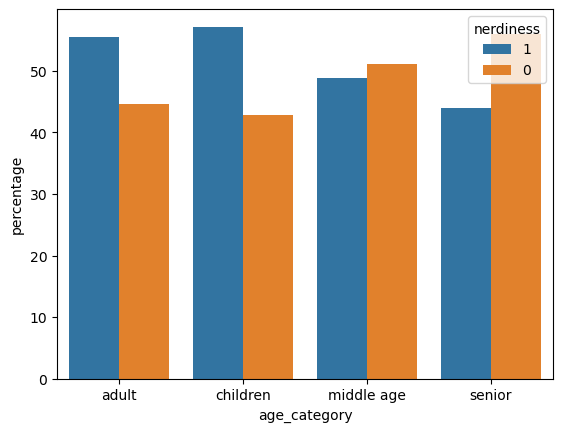

In [34]:
train['age_category'] = train['age'].apply(lambda x : age_to_category(x))
counts = train.groupby('age_category')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'age_category', y = 'percentage', hue = 'nerdiness', data = counts)
test['age_category'] = test['age'].apply(lambda x : age_to_category(x))


In [35]:
# 특정 종교와 관련하여 nerdiness 변화가 뚜렷함.
def convert_environment(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return '0'
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return '1'
    else:
        return '2'


train['religion_environment'] = train['religion'].apply(lambda x : convert_environment(x))
test['religion_environment'] = test['religion'].apply(lambda x : convert_environment(x))

In [39]:
# age, religion -> 삭제
train.drop(['age', 'religion'], axis = 1, inplace = True)
test.drop(['age', 'religion'], axis = 1, inplace = True)

In [40]:
time = ['introelapse', 'testelapse', 'surveyelapse']
train[time].describe()

,introelapse,testelapse,surveyelapse
count,15000.000000,15000.000000,1.500000e+04
mean,767.137756,387.965668,2.787958e+03
std,13835.948242,8513.031250,1.785955e+05
min,1.000000,1.000000,3.000000e+00
25%,4.000000,82.000000,1.260000e+02
50%,10.000000,106.000000,1.640000e+02
75%,36.000000,140.000000,2.170000e+02
max,855030.000000,474572.000000,1.516699e+07
